<a href="https://colab.research.google.com/github/kategavrishina/srl-modeling/blob/main/SRL_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
%cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [3]:
! pip install gensim

In [4]:
! pip install tensorflow-text tensorflow-hub

     |████████████████████████████████| 4.3MB 6.9MB/s 
     |████████████████████████████████| 454.3MB 35kB/s 
     |████████████████████████████████| 4.0MB 37.7MB/s 
     |████████████████████████████████| 1.2MB 43.5MB/s 
     |████████████████████████████████| 6.0MB 25.1MB/s 
     |████████████████████████████████| 4.0MB 18.9MB/s 
     |████████████████████████████████| 471kB 59.2MB/s 
     |████████████████████████████████| 4.9MB 24.2MB/s 
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing ins

In [5]:
import json
import pandas as pd
import gensim
import urllib.request
from collections import Counter

from tqdm import tqdm
from gensim.models import word2vec

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
tqdm.pandas()

Данные [framebank](http://nlp.isa.ru/framebank_parser/data/), синтаксическая разметка при помощи SyntaxNet

In [ ]:
with open('annotated_corpus_fixed+syntaxnet.json', 'r', encoding='utf-8') as f:
    syntax = json.load(f)

In [ ]:
length = 0
for el in syntax:
    length += len(el)
print('Количество предложений в корпусе framebank+syntaxnet:', length)

Количество предложений в корпусе framebank+syntaxnet: 322357


In [ ]:
len(syntax.keys())

59860

# Создание датафрейма из json-формата Framebank

In [ ]:
syntax_df = pd.DataFrame(columns=['ExIndex', 'SentIndex', 'feat', 'feat_p', 'form', 'lemma',
                           'link_name', 'parent', 'postag_p', 'rank', 'rolepred1', 'sem', 'sem2'])

In [ ]:
for key in tqdm(list(syntax.keys())):
    for i, example in enumerate(syntax[key]):
        temp = pd.DataFrame.from_dict(example)
        if 'rank' in temp.columns:
            temp['ExIndex'] = key
            temp['SentIndex'] = i
            syntax_df = syntax_df.append(temp)

In [ ]:
syntax_df.reset_index(inplace=True)

Количество предложений в корпусе framebank с размеченной структурой ролей

In [ ]:
len(syntax_df['FullIndex'].unique())

7952

Приведение данных к формату корпуса [SynTagRus](https://github.com/UniversalDependencies/UD_Russian-SynTagRus)


*   Индексация должна начинаться с 1
*   Некоторые признаки избыточны (семантика, синтаксический ранг, fPOS, feat - морфолгические признаки в неудобном формате, индекс предиката)





In [ ]:
syntax_df['index'] += 1

In [ ]:
syntax_df['parent'] += 1

In [ ]:
syntax_df['fillpred'] += 1

In [ ]:
syntax_df['FullIndex'] = syntax_df['ExIndex'] + '_' + syntax_df['SentIndex'].astype('str')

In [ ]:
syntax_df.drop(['feat', 'sem', 'sem2', 'pred'], axis=1, inplace=True)

In [ ]:
syntax_df.rename(columns={'postag_p':'POS', 'rolepred1':'Role', 'fillpred':'lemma_pred'}, inplace=True)

In [ ]:
syntax_df.head()

,index,ExIndex,SentIndex,feat_p,form,lemma,link_name,parent,POS,rank,Role,lemma_pred,FullIndex
0,1,106303,3,Degree=Pos|fPOS=ADV++,Уже,уже,advmod,2,ADV,NaN,NaN,NaN,106303_3
1,2,106303,3,Aspect=Imp|Mood=Imp|Number=Sing|Person=2|VerbF...,май,май,ROOT,0,NOUN,NaN,NaN,NaN,106303_3
2,3,106303,3,"fPOS=PUNCT++,",",",NaN,punct,2,PUNCT,NaN,NaN,NaN,106303_3
3,4,106303,3,Aspect=Imp|Mood=Ind|Number=Plur|Person=3|Tense...,цветут,цвести,conj,2,VERB,Предикат,NaN,NaN,106303_3
4,5,106303,3,Case=Nom|Degree=Pos|Number=Plur|fPOS=ADJ++,вишнёвые,вишневый,amod,6,ADJ,NaN,NaN,NaN,106303_3


In [ ]:
syntax_df.shape

(215437, 13)

In [ ]:
def change_feat_p(feats):
    if feats.startswith('fPOS'):
        return '_'
    else:
        return feats.split('|fPOS')[0]

In [ ]:
syntax_df['feat_p'] = syntax_df['feat_p'].progress_apply(lambda x: change_feat_p(x))

100%|██████████| 215437/215437 [00:00<00:00, 722724.73it/s]


Будем считать синтаксический ранг "Предикат" одной из предсказываемых семантчиеских ролей

In [ ]:
for index, row in syntax_df[syntax_df['rank'] == 'Предикат'].iterrows():
    syntax_df.loc[index, 'Role'] = 'предикат'

In [ ]:
syntax_df['lemma'].fillna(syntax_df['form'], inplace=True)

In [ ]:
syntax_df.drop('rank', axis=1, inplace=True)

In [ ]:
syntax_df.replace({'ROOT': 'root', 'CONJ': 'CCONJ'}, inplace=True)

In [ ]:
syntax_df.fillna('_', inplace=True)

In [ ]:
syntax_df.head()

,index,ExIndex,SentIndex,feat_p,form,lemma,link_name,parent,POS,Role,lemma_pred,FullIndex
0,1,106303,3,Degree=Pos,Уже,уже,advmod,2,ADV,_,_,106303_3
1,2,106303,3,Aspect=Imp|Mood=Imp|Number=Sing|Person=2|VerbF...,май,май,root,0,NOUN,_,_,106303_3
2,3,106303,3,_,",",",",punct,2,PUNCT,_,_,106303_3
3,4,106303,3,Aspect=Imp|Mood=Ind|Number=Plur|Person=3|Tense...,цветут,цвести,conj,2,VERB,предикат,_,106303_3
4,5,106303,3,Case=Nom|Degree=Pos|Number=Plur,вишнёвые,вишневый,amod,6,ADJ,_,_,106303_3


Что может быть предикатом?

In [ ]:
predicates = Counter(syntax_df[syntax_df['Role'] == 'предикат']['POS'])
[(l,k) for k,l in sorted([(j,i) for i,j in predicates.items()], reverse=True)]

[('VERB', 7216),
 ('NOUN', 79),
 ('ADJ', 43),
 ('PART', 5),
 ('ADV', 5),
 ('AUX', 4),
 ('ADP', 4),
 ('PUNCT', 1)]

Добавляем признаки: лемма и часть речи вершины

In [ ]:
for index, row in tqdm(syntax_df.iterrows()):
    parent = row.parent
    fullindex = row.FullIndex
    if parent != 0:
        value = syntax_df.loc[(syntax_df['FullIndex'] == fullindex) & (syntax_df['index'] == parent)]
        syntax_df.loc[index, 'lemma_parent'] = value['lemma'].values[0]
        syntax_df.loc[index, 'pos_parent'] = value['POS'].values[0]
    else:
        syntax_df.loc[index, 'lemma_parent'] = '_'
        syntax_df.loc[index, 'pos_parent'] = '_'

215437it [1:02:32, 57.42it/s]


Добавляем новый признак - положение зависимого относительно вершины (до/после и на каком расстоянии)

In [ ]:
def create_parent_index(self_index, parent_index):
    if int(parent_index) != 0:
        return int(parent_index) - int(self_index)
    else:
        return 0

In [ ]:
syntax_df['parent'] = syntax_df[['index', 'parent']].progress_apply(lambda x: create_parent_index(*x), axis=1)

100%|██████████| 215437/215437 [00:02<00:00, 98838.91it/s] 


In [ ]:
syntax_df.drop(['lemma_pred', 'ExIndex', 'SentIndex', 'form'], axis=1, inplace=True)

In [9]:
syntax_df = pd.read_csv('syntax_simple.xlsx', sep='\t', index_col=0)

In [10]:
x = Counter(syntax_df['Role'])

In [11]:
[(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)][:10]

[('_', 193988),
 ('предикат', 7357),
 ('агенс', 1441),
 ('пациенс', 1266),
 ('тема', 971),
 ('субъект психологического состояния', 677),
 ('субъект перемещения', 659),
 ('говорящий', 573),
 ('причина', 567),
 ('содержание высказывания', 521)]

In [12]:
[(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)][-10:]

[('источник звука - пациенс', 1),
 ('значение параметра - начальная точка', 1),
 ('значение параметра - конечная точка', 1),
 ('запах метаф.', 1),
 ('заместитель', 1),
 ('говорящий - субъект физиологической реакции', 1),
 ('говорящий - субъект ментального состояния', 1),
 ('агенс / субъект ментального состояния', 1),
 ('агенс - конечный посессор', 1),
 ('агенс - говорящий', 1)]

Удаляем редкие роли (< 20 примеров)

In [13]:
for index, row in tqdm(syntax_df.iterrows()):
    if x[row['Role']] < 20:
        syntax_df.at[index, 'Role'] = '_'

215437it [00:17, 12631.92it/s]


In [14]:
len(syntax_df[syntax_df['Role'] == 'предикат']['lemma'].unique())

609

# Словари для кодирования признаков

In [15]:
syntax_df['lemma'] = syntax_df['lemma'].astype('str')

In [16]:
groups = syntax_df.groupby('FullIndex').indices

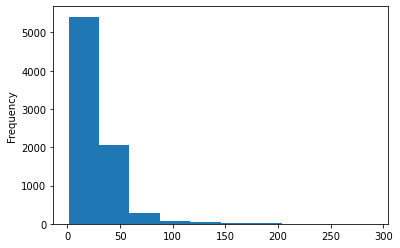

In [17]:
syntax_df['FullIndex'].value_counts().plot(kind='hist')

**Максимальную длину последовательности** берём из данных **SynTagRus**, которые позднее будут использованы в качестве тестовых

In [18]:
sent_max_len = 123

Удаляем из выборки предложения, которые превышают максимальную длину

In [19]:
for full_index in groups.keys():
    if len(syntax_df[syntax_df.FullIndex == full_index]) > sent_max_len:
        syntax_df.drop(syntax_df[syntax_df.FullIndex == full_index].index, inplace=True)

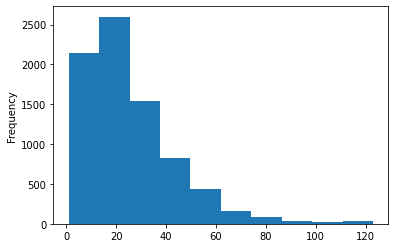

In [20]:
syntax_df['FullIndex'].value_counts().plot(kind='hist')

In [21]:
len(syntax_df['FullIndex'].unique())

7872

Делим данные корпуса framebank на обучающую, валидационную и тестовую выборки

In [22]:
train_index, test_index = train_test_split(list(groups.keys()), test_size=0.2, random_state=123)

In [23]:
train_index, val_index = train_test_split(train_index, test_size=0.25, random_state=123)

In [24]:
len(train_index), len(val_index), len(test_index)

(4770, 1591, 1591)

Словарь лемм

In [25]:
vocab = Counter()
for full_index in train_index:
    start = groups[full_index][0]
    end = groups[full_index][-1]
    vocab.update(syntax_df.lemma[start:end+1])

In [26]:
word2id = {'unk':1, 'pad':0}

for word in vocab:
    word2id[word] = len(word2id)

In [27]:
id2word = {i:word for word, i in word2id.items()}

Части речи

In [28]:
pos2id = {'pad':0, 'unk':1}  
for full_index in train_index:
    start = groups[full_index][0]
    end = groups[full_index][-1]
    tags = syntax_df.POS[start:end+1]
    for tag in tags:
      if tag not in pos2id:
        pos2id[tag] = len(pos2id)

id2pos = {i:tag for tag, i in pos2id.items()}

Синтаксическая информация

In [29]:
rank2id = {'pad':0, 'unk':1}  
for full_index in train_index:
    start = groups[full_index][0]
    end = groups[full_index][-1]
    tags = syntax_df.link_name[start:end+1]
    for tag in tags:
      if tag not in rank2id:
        rank2id[tag] = len(rank2id)

id2rank = {i:tag for tag, i in rank2id.items()}

Морфологические признаки

In [30]:
morph2id = {'pad':0, 'unk':1}  
for full_index in train_index:
    start = groups[full_index][0]
    end = groups[full_index][-1]
    tags = syntax_df.feat_p[start:end+1]
    for tag in tags:
      if tag not in morph2id:
        morph2id[tag] = len(morph2id)

id2morph = {i:tag for tag, i in morph2id.items()}

Расположение относительно вершины

In [31]:
rel2id = {'pad':0, 'unk':1}  
for full_index in train_index:
    start = groups[full_index][0]
    end = groups[full_index][-1]
    tags = syntax_df.parent[start:end+1]
    for tag in tags:
      if tag not in rel2id:
        rel2id[tag] = len(rel2id)

id2rel = {i:tag for tag, i in rel2id.items()}

Целевая переменная - семантическая роль

In [32]:
role2id = {'pad':0, 'unk':1}  
for full_index in train_index:
    start = groups[full_index][0]
    end = groups[full_index][-1]
    tags = syntax_df.Role[start:end+1]
    for tag in tags:
      if tag not in role2id:
        role2id[tag] = len(role2id)

id2role = {i:tag for tag, i in role2id.items()}

In [33]:
def data2ints(train_or_test_index, column, smth2id):
    int_data = []
    for full_index in train_or_test_index:
        start = groups[full_index][0]
        end = groups[full_index][-1]
        seq = column[start:end+1]
        int_seq = []
        for i in seq:
          int_seq.append(smth2id.get(i, 1))
  
        int_data.append(int_seq)
    return int_data

In [34]:
X_train_sent_ids, X_val_sent_ids, X_test_sent_ids = data2ints(train_index, syntax_df.lemma, word2id),data2ints(val_index, syntax_df.lemma, word2id), data2ints(test_index, syntax_df.lemma, word2id)
X_train_pos_ids, X_val_pos_ids, X_test_pos_ids = data2ints(train_index, syntax_df.POS, pos2id), data2ints(val_index, syntax_df.POS, pos2id), data2ints(test_index, syntax_df.POS, pos2id)
X_train_rank_ids, X_val_rank_ids, X_test_rank_ids = data2ints(train_index, syntax_df.link_name, rank2id), data2ints(val_index, syntax_df.link_name, rank2id), data2ints(test_index, syntax_df.link_name, rank2id)
X_train_morph_ids, X_val_morph_ids, X_test_morph_ids = data2ints(train_index, syntax_df.feat_p, morph2id), data2ints(val_index, syntax_df.feat_p, morph2id), data2ints(test_index, syntax_df.feat_p, morph2id)
X_train_rel_ids, X_val_rel_ids, X_test_rel_ids = data2ints(train_index, syntax_df.parent, rel2id), data2ints(val_index, syntax_df.parent, rel2id), data2ints(test_index, syntax_df.parent, rel2id)
X_train_head_ids, X_val_head_ids, X_test_head_ids = data2ints(train_index, syntax_df.lemma_parent, word2id), data2ints(val_index, syntax_df.lemma_parent, word2id), data2ints(test_index, syntax_df.lemma_parent, word2id)
X_train_headpos_ids, X_val_headpos_ids, X_test_headpos_ids = data2ints(train_index, syntax_df.pos_parent, pos2id), data2ints(val_index, syntax_df.pos_parent, pos2id), data2ints(test_index, syntax_df.pos_parent, pos2id)

y_train_ids, y_val_ids, y_test_ids = data2ints(train_index, syntax_df.Role, role2id), data2ints(val_index, syntax_df.Role, role2id), data2ints(test_index, syntax_df.Role, role2id)

In [35]:
print("максимальная длина предложения:", sent_max_len)

максимальная длина предложения: 123


Добавляем паддинг

In [36]:
X_train_sent, X_val_sent, X_test_sent = pad_sequences(X_train_sent_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_val_sent_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_sent_ids, maxlen=sent_max_len, padding='post')
X_train_pos, X_val_pos, X_test_pos = pad_sequences(X_train_pos_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_val_pos_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_pos_ids, maxlen=sent_max_len, padding='post')
X_train_rank, X_val_rank, X_test_rank = pad_sequences(X_train_rank_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_val_rank_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_rank_ids, maxlen=sent_max_len, padding='post')
X_train_morph, X_val_morph, X_test_morph = pad_sequences(X_train_morph_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_val_morph_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_morph_ids, maxlen=sent_max_len, padding='post')
X_train_rel, X_val_rel, X_test_rel = pad_sequences(X_train_rel_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_val_rel_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_rel_ids, maxlen=sent_max_len, padding='post')
X_train_head, X_val_head, X_test_head = pad_sequences(X_train_head_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_val_head_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_head_ids, maxlen=sent_max_len, padding='post')
X_train_headpos, X_val_headpos, X_test_headpos = pad_sequences(X_train_headpos_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_val_headpos_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_headpos_ids, maxlen=sent_max_len, padding='post')

y_train, y_val, y_test = pad_sequences(y_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(y_val_ids, maxlen=sent_max_len, padding='post'), pad_sequences(y_test_ids, maxlen=sent_max_len, padding='post')

In [37]:
print(X_train_sent.shape, y_train.shape, X_val_sent.shape, y_val.shape, X_test_sent.shape, y_test.shape)

(4770, 123) (4770, 123) (1591, 123) (1591, 123) (1591, 123) (1591, 123)


In [38]:
y_train, y_val, y_test = to_categorical(y_train, num_classes=len(role2id)), to_categorical(y_val, num_classes=len(role2id)), to_categorical(y_test, num_classes=len(role2id))

In [39]:
y_train.shape

(4770, 123, 71)

Матрица весов для эмбеддинг-слоя

### Предобученная модель 1
ruwikiruscorpora_upos_skipgram_300_2_2019	608 Мбайт	НКРЯ и Википедия за декабрь 2018	788 миллионов слов	248 978	5 (потолок словаря 250К)	Universal Tags	Continuous Skipgram	300

In [ ]:
urllib.request.urlretrieve("http://vectors.nlpl.eu/repository/20/182.zip", "182.zip")

('182.zip', <http.client.HTTPMessage at 0x7faf485f2b50>)

In [ ]:
! unzip 182.zip

In [40]:
m = 'model.bin'

model_gensim_1 = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

### Предобученная модель 2
news_upos_skipgram_300_5_2019	611 Мбайт	Русскоязычные новости	2.6 миллиарда слов	249 318	5 (потолок словаря 250К)	Universal Tags	Continuous Skipgram	300

In [ ]:
urllib.request.urlretrieve("http://vectors.nlpl.eu/repository/20/184.zip", "184.zip")

('184.zip', <http.client.HTTPMessage at 0x7faefcf0afd0>)

In [ ]:
! unzip 184.zip

In [41]:
m = 'model_2.bin'

model_gensim_2 = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

### Предобученная модель 3

In [42]:
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
use_model = hub.load(module_url)
print("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder-multilingual/3 loaded


In [43]:
import numpy as np
import tqdm.notebook as tq


def use_get_embedding(text, model):
    return model([text]).numpy()[0]

def use_records_to_embeds(list_text, model):
    embeddings = np.zeros((len(list_text), 512))
    for i in tq.tqdm(range(len(list_text))):
        embeddings[i] = use_get_embedding(list_text[i], model)
    return embeddings

In [44]:
lemma_pos = dict(zip(syntax_df['lemma'], syntax_df['POS']))

In [45]:
import numpy as np

In [46]:
def create_weights_w2v(vocab, model_gensim, dict_of_forms):
    weights = []
    not_found = 0
    for word in vocab.values():
        if word != 'unk' and word != 'pad':
            norm_pos = str(word) + '_' + dict_of_forms[word]
            if norm_pos in model_gensim:
                weights.append(model_gensim[norm_pos])
            else:
                not_found += 1
                weights.append(np.zeros(model_gensim.vector_size))
        else:
            weights.append(np.zeros(model_gensim.vector_size))
    print("Не найдено в модели:", not_found)
    return np.asarray(weights)

In [47]:
weights = create_weights_w2v(id2word, model_gensim_1, lemma_pos)

Не найдено в модели: 3450


In [48]:
weights_2 = create_weights_w2v(id2word, model_gensim_2, lemma_pos)

Не найдено в модели: 4340


In [49]:
weights_3 = use_records_to_embeds([word for word in id2word.values()], use_model)

In [50]:
syntax_df.head()

,index,feat_p,lemma,link_name,parent,POS,Role,FullIndex,lemma_parent,pos_parent
0,1,Degree=Pos,уже,advmod,1,ADV,_,106303_3,май,NOUN
1,2,Aspect=Imp|Mood=Imp|Number=Sing|Person=2|VerbF...,май,root,0,NOUN,_,106303_3,_,_
2,3,_,",",punct,-1,PUNCT,_,106303_3,май,NOUN
3,4,Aspect=Imp|Mood=Ind|Number=Plur|Person=3|Tense...,цвести,conj,-2,VERB,предикат,106303_3,май,NOUN
4,5,Case=Nom|Degree=Pos|Number=Plur,вишневый,amod,1,ADJ,_,106303_3,дерево,NOUN


# Сеть

In [51]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, TimeDistributed, InputLayer
from tensorflow.keras.layers import Embedding, Conv1D, Input, concatenate, SpatialDropout1D, Flatten, Attention, Layer
from tensorflow.keras import optimizers

In [52]:
from tensorflow.keras.metrics import Accuracy, Precision, Recall

In [53]:
import tensorflow.keras.backend as K

In [54]:
import tensorflow as tf

In [55]:
def ignore_accuracy(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)

    ignore_mask = K.cast(K.not_equal(y_pred_class, role2id['_']), 'int32')
    ignore_mask_2 = K.cast(K.not_equal(y_pred_class, role2id['pad']), 'int32')
    matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * (ignore_mask & ignore_mask_2)
    accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask & ignore_mask_2), 1)
    return accuracy

In [56]:
def predicate_recall(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    accuracy_mask = K.cast(K.equal(class_id_true, role2id['предикат']), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

def predicate_precision(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    accuracy_mask = K.cast(K.equal(class_id_preds, role2id['предикат']), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc
    
def agent_recall(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    accuracy_mask = K.cast(K.equal(class_id_true, role2id['агенс']), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

def agent_precision(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    accuracy_mask = K.cast(K.equal(class_id_preds, role2id['агенс']), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc
    
def patient_recall(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    accuracy_mask = K.cast(K.equal(class_id_true, role2id['пациенс']), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

def patient_precision(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    accuracy_mask = K.cast(K.equal(class_id_preds, role2id['пациенс']), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

## Модель 1 (4 входа, biLSTM, Dense)

In [87]:
# один вход для лексических эмбеддингов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights], mask_zero=True)(word_in)

# другой вход для частей речи
pos_in = Input(shape=(sent_max_len))
emb_pos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(pos_in)

# и вход для синтаксических рангов
rank_in = Input(shape=(sent_max_len))
emb_rank = Embedding(input_dim=len(rank2id), output_dim=30, mask_zero=True)(rank_in)

# и вход для морф признаков
morph_in = Input(shape=(sent_max_len))
emb_morph = Embedding(input_dim=len(morph2id), output_dim=100, mask_zero=True)(morph_in)

x = concatenate([emb_word, emb_pos, emb_rank, emb_morph])

main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)

out = TimeDistributed(Dense(len(role2id), activation="softmax"))(main_lstm)

model_1 = Model(inputs=[word_in, pos_in, rank_in, morph_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc", Precision(), Recall(), ignore_accuracy])

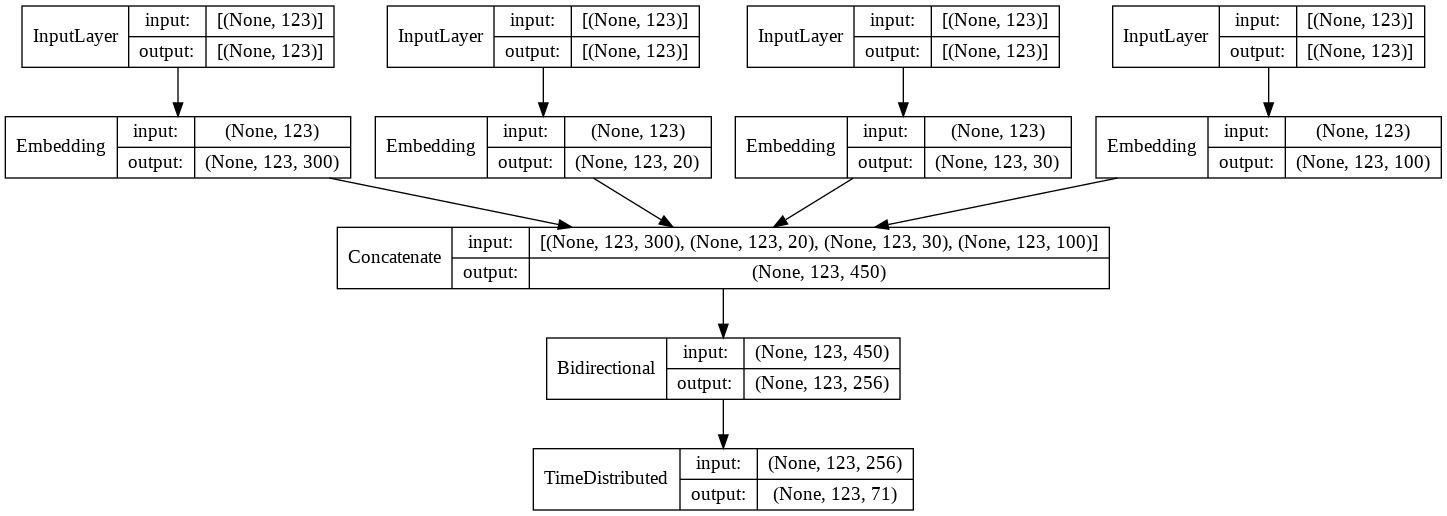

In [88]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, show_shapes=True, show_layer_names=False)

In [89]:
model_1.fit([X_train_sent, X_train_pos, X_train_rank, X_train_morph], y_train,
          validation_data=([X_val_sent, X_val_pos, X_val_rank, X_val_morph], y_val),
          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
38/38 [==============================] - 90s 2s/step - loss: 0.2596 - acc: 0.8733 - precision_2: 0.8960 - recall_2: 0.6861 - ignore_accuracy: 2.5445e-05 - val_loss: 0.1377 - val_acc: 0.8984 - val_precision_2: 0.8971 - val_recall_2: 0.8551 - val_ignore_accuracy: 0.0000e+00
Epoch 2/15
38/38 [==============================] - 84s 2s/step - loss: 0.1268 - acc: 0.8982 - precision_2: 0.8990 - recall_2: 0.8852 - ignore_accuracy: 0.0000e+00 - val_loss: 0.1196 - val_acc: 0.8984 - val_precision_2: 0.9009 - val_recall_2: 0.8876 - val_ignore_accuracy: 0.0000e+00
Epoch 3/15
38/38 [==============================] - 84s 2s/step - loss: 0.1120 - acc: 0.8983 - precision_2: 0.9028 - recall_2: 0.8865 - ignore_accuracy: 0.2832 - val_loss: 0.1068 - val_acc: 0.8992 - val_precision_2: 0.9050 - val_recall_2: 0.8836 - val_ignore_accuracy: 0.6593
Epoch 4/15
38/38 [==============================] - 83s 2s/step - loss: 0.1015 - acc: 0.8996 - precision_2: 0.9064 - recall_2: 0.8857 - ignore_accuracy: 0.5

In [90]:
model_1.save('my_model_1')

INFO:tensorflow:Assets written to: my_model_1/assets


INFO:tensorflow:Assets written to: my_model_1/assets


In [91]:
eval_results_1 = model_1.evaluate(x=[X_test_sent, X_test_pos, X_test_rank, X_test_morph],
               y=y_test)

50/50 [==============================] - 9s 182ms/step - loss: 0.0796 - acc: 0.9054 - precision_2: 0.9123 - recall_2: 0.8997 - ignore_accuracy: 0.6936


In [98]:
metrics_df = pd.DataFrame(columns=['Model type', 'Loss', 'Accuracy', 'Precision', 'Recall', 'Custom accuracy'])

In [99]:
metrics_df.loc[len(metrics_df)] = ['4 Input, biLSTM, Dense', eval_results_1[0], eval_results_1[1], eval_results_1[2], eval_results_1[3], eval_results_1[4]]

In [100]:
metrics_df

,Model type,Loss,Accuracy,Precision,Recall,Custom accuracy
0,"4 Input, biLSTM, Dense",0.079551,0.905396,0.912322,0.899707,0.693643


In [92]:
preds_1 = model_1.predict([X_test_sent, X_test_pos, X_test_rank, X_test_morph])

In [93]:
pred_pr_1 = predicate_precision(y_test, preds_1).numpy()
pred_re_1 = predicate_recall(y_test, preds_1).numpy()
agent_pr_1 = agent_precision(y_test, preds_1).numpy()
agent_re_1 = agent_recall(y_test, preds_1).numpy()
patient_pr_1 = patient_precision(y_test, preds_1).numpy()
patient_re_1 = patient_recall(y_test, preds_1).numpy()

In [94]:
role_metrics_df = pd.DataFrame(columns=['Model type', 'Predicate Precision', 'Predicate Recall', 'Agent Precision', 'Agent Recall', 'Patient Precision', 'Patient Recall'])

In [95]:
role_metrics_df.loc[len(role_metrics_df)] = ['4 Input, biLSTM, Dense', pred_pr_1, pred_re_1, agent_pr_1, agent_re_1, patient_pr_1, patient_re_1]

In [96]:
role_metrics_df

,Model type,Predicate Precision,Predicate Recall,Agent Precision,Agent Recall,Patient Precision,Patient Recall
0,"4 Input, biLSTM, Dense",0.706337,0.322058,0.25,0.003497,0.0,0.0


## Модель 2 (7 входов, biLSTM, Dense)

In [58]:
# один вход для лексических эмбеддингов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights], mask_zero=True)(word_in)

# другой вход для частей речи
pos_in = Input(shape=(sent_max_len))
emb_pos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(pos_in)

# и вход для синтаксических рангов
rank_in = Input(shape=(sent_max_len))
emb_rank = Embedding(input_dim=len(rank2id), output_dim=30, mask_zero=True)(rank_in)

# и вход для морф признаков
morph_in = Input(shape=(sent_max_len))
emb_morph = Embedding(input_dim=len(morph2id), output_dim=100, mask_zero=True)(morph_in)

# и вход для отношения к вершине
rel_in = Input(shape=(sent_max_len))
emb_rel = Embedding(input_dim=len(rel2id), output_dim=20, mask_zero=True)(rel_in)

# один вход для лексических эмбеддингов вершин
head_in = Input(shape=(sent_max_len))
emb_head = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights], mask_zero=True)(head_in)

# другой вход для частей речи вершин
headpos_in = Input(shape=(sent_max_len))
emb_headpos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(headpos_in)

x = concatenate([emb_word, emb_pos, emb_rank, emb_morph, emb_rel, emb_head, emb_headpos])

main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)

out = TimeDistributed(Dense(len(role2id), activation="softmax"))(main_lstm)

model_2 = Model(inputs=[word_in, pos_in, rank_in, morph_in, rel_in, head_in, headpos_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc", Precision(), Recall(), ignore_accuracy])

In [59]:
model_2.fit([X_train_sent, X_train_pos, X_train_rank, X_train_morph, X_train_rel, X_train_head, X_train_headpos], y_train,
          validation_data=([X_val_sent, X_val_pos, X_val_rank, X_val_morph, X_val_rel, X_val_head, X_val_headpos], y_val),
          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
38/38 [==============================] - 143s 4s/step - loss: 0.2128 - acc: 0.8726 - precision_1: 0.8976 - recall_1: 0.7583 - ignore_accuracy: 2.6523e-04 - val_loss: 0.1279 - val_acc: 0.8984 - val_precision_1: 0.8985 - val_recall_1: 0.8770 - val_ignore_accuracy: 0.0000e+00
Epoch 2/15
38/38 [==============================] - 135s 4s/step - loss: 0.1156 - acc: 0.8982 - precision_1: 0.9002 - recall_1: 0.8885 - ignore_accuracy: 0.0580 - val_loss: 0.1087 - val_acc: 0.8987 - val_precision_1: 0.9048 - val_recall_1: 0.8842 - val_ignore_accuracy: 0.5921
Epoch 3/15
38/38 [==============================] - 135s 4s/step - loss: 0.1018 - acc: 0.8994 - precision_1: 0.9059 - recall_1: 0.8869 - ignore_accuracy: 0.6171 - val_loss: 0.0971 - val_acc: 0.9019 - val_precision_1: 0.9104 - val_recall_1: 0.8867 - val_ignore_accuracy: 0.6538
Epoch 4/15
38/38 [==============================] - 135s 4s/step - loss: 0.0933 - acc: 0.9005 - precision_1: 0.9091 - recall_1: 0.8882 - ignore_accuracy: 0.5731 

In [60]:
model_2.save('my_model_2')

INFO:tensorflow:Assets written to: my_model_2/assets


INFO:tensorflow:Assets written to: my_model_2/assets


In [61]:
eval_results_2 = model_2.evaluate(x=[X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos],
                                y=y_test)

50/50 [==============================] - 17s 342ms/step - loss: 0.0698 - acc: 0.9088 - precision_1: 0.9252 - recall_1: 0.8947 - ignore_accuracy: 0.5997


In [71]:
metrics_df.loc[len(metrics_df)] = ['7 Input, biLSTM, Dense', eval_results_2[0], eval_results_2[1], eval_results_2[2], eval_results_2[3], eval_results_2[4]]

In [83]:
metrics_df

,Model type,Loss,Accuracy,Precision,Recall,Custom accuracy
0,"4 Input, biLSTM, Dense",0.079551,0.905396,0.912322,0.899707,0.693643
1,"7 Input, biLSTM, Dense",0.069799,0.908815,0.925157,0.894731,0.599692


In [62]:
preds_2 = model_2.predict([X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos])

In [63]:
pred_pr_2 = predicate_precision(y_test, preds_2).numpy()
pred_re_2 = predicate_recall(y_test, preds_2).numpy()
agent_pr_2 = agent_precision(y_test, preds_2).numpy()
agent_re_2 = agent_recall(y_test, preds_2).numpy()
patient_pr_2 = patient_precision(y_test, preds_2).numpy()
patient_re_2 = patient_recall(y_test, preds_2).numpy()

In [66]:
role_metrics_df.loc[len(role_metrics_df)] = ['7 Input, biLSTM, Dense', pred_pr_2, pred_re_2, agent_pr_2, agent_re_2, patient_pr_2, patient_re_2]

In [67]:
role_metrics_df

,Model type,Predicate Precision,Predicate Recall,Agent Precision,Agent Recall,Patient Precision,Patient Recall
0,"4 Input, biLSTM, Dense",0.706337,0.322058,0.250000,0.003497,0.000000,0.00
1,"7 Input, biLSTM, Dense",0.635135,0.496829,0.488372,0.073427,0.483871,0.06


## Модель 3 (7 входов + Dense, biLSTM, Dense)

In [73]:
# один вход для лексических эмбеддингов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights], mask_zero=True)(word_in)
word_dense = Dense(128, activation='relu')(emb_word)
word_dense = Dropout(0.5)(word_dense)

# другой вход для частей речи
pos_in = Input(shape=(sent_max_len))
emb_pos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(pos_in)
pos_dense = Dense(128, activation='relu')(emb_pos)
pos_dense = Dropout(0.5)(pos_dense)

# и вход для синтаксических рангов
rank_in = Input(shape=(sent_max_len))
emb_rank = Embedding(input_dim=len(rank2id), output_dim=30, mask_zero=True)(rank_in)
rank_dense = Dense(128, activation='relu')(emb_rank)
rank_dense = Dropout(0.5)(rank_dense)

# и вход для морф признаков
morph_in = Input(shape=(sent_max_len))
emb_morph = Embedding(input_dim=len(morph2id), output_dim=100, mask_zero=True)(morph_in)
morph_dense = Dense(128, activation='relu')(emb_morph)
morph_dense = Dropout(0.5)(morph_dense)

# и вход для отношения к вершине
rel_in = Input(shape=(sent_max_len))
emb_rel = Embedding(input_dim=len(rel2id), output_dim=20, mask_zero=True)(rel_in)
rel_dense = Dense(128, activation='relu')(emb_rel)
rel_dense = Dropout(0.5)(rel_dense)

# один вход для лексических эмбеддингов вершин
head_in = Input(shape=(sent_max_len))
emb_head = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights], mask_zero=True)(head_in)
head_dense = Dense(128, activation='relu')(emb_head)
head_dense = Dropout(0.5)(head_dense)

# другой вход для частей речи вершин
headpos_in = Input(shape=(sent_max_len))
emb_headpos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(headpos_in)
headpos_dense = Dense(128, activation='relu')(emb_headpos)
headpos_dense = Dropout(0.5)(headpos_dense)

x = concatenate([word_dense, pos_dense, rank_dense, morph_dense, rel_dense, head_dense, headpos_dense])

main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.3))(x)

out = TimeDistributed(Dense(len(role2id), activation="softmax"))(main_lstm)

model_3 = Model(inputs=[word_in, pos_in, rank_in, morph_in, rel_in, head_in, headpos_in], outputs=out)

optimizer = optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc", Precision(), Recall(), ignore_accuracy])

In [74]:
model_3.fit([X_train_sent, X_train_pos, X_train_rank, X_train_morph, X_train_rel, X_train_head, X_train_headpos], y_train,
          validation_data=([X_val_sent, X_val_pos, X_val_rank, X_val_morph, X_val_rel, X_val_head, X_val_headpos], y_val),
          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
38/38 [==============================] - 164s 4s/step - loss: 0.2228 - acc: 0.8742 - precision_2: 0.8981 - recall_2: 0.7495 - ignore_accuracy: 2.5058e-05 - val_loss: 0.1273 - val_acc: 0.8984 - val_precision_2: 0.8980 - val_recall_2: 0.8942 - val_ignore_accuracy: 0.0000e+00
Epoch 2/15
38/38 [==============================] - 155s 4s/step - loss: 0.1161 - acc: 0.8982 - precision_2: 0.8998 - recall_2: 0.8949 - ignore_accuracy: 7.8588e-05 - val_loss: 0.1054 - val_acc: 0.8989 - val_precision_2: 0.9017 - val_recall_2: 0.8946 - val_ignore_accuracy: 2.3050e-04
Epoch 3/15
38/38 [==============================] - 155s 4s/step - loss: 0.0993 - acc: 0.8986 - precision_2: 0.9026 - recall_2: 0.8928 - ignore_accuracy: 0.0013 - val_loss: 0.0934 - val_acc: 0.9025 - val_precision_2: 0.9067 - val_recall_2: 0.8973 - val_ignore_accuracy: 0.6515
Epoch 4/15
38/38 [==============================] - 155s 4s/step - loss: 0.0932 - acc: 0.8994 - precision_2: 0.9050 - recall_2: 0.8929 - ignore_accuracy:

In [75]:
model_3.save('my_model_3')

INFO:tensorflow:Assets written to: my_model_3/assets


INFO:tensorflow:Assets written to: my_model_3/assets


In [76]:
eval_results_3 = model_3.evaluate(x=[X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos],
                                y=y_test)

50/50 [==============================] - 18s 369ms/step - loss: 0.0669 - acc: 0.9172 - precision_2: 0.9395 - recall_2: 0.8990 - ignore_accuracy: 0.6588


In [ ]:
metrics_df = pd.read_csv('metrics.xlsx', sep='\t', index_col=0)

In [88]:
metrics_df.loc[len(metrics_df)] = ['7 Input, Dense, biLSTM, Dense', eval_results_3[0], eval_results_3[1], eval_results_3[2], eval_results_3[3], eval_results_3[4]]

In [155]:
metrics_df

,Model type,Loss,Accuracy,Precision,Recall,Custom accuracy
0,"4 Input, biLSTM, Dense",0.079551,0.905396,0.912322,0.899707,0.693643
1,"7 Input, biLSTM, Dense",0.069799,0.908815,0.925157,0.894731,0.599692
2,"7 Input, Dense, biLSTM, Dense",0.066909,0.917183,0.939530,0.899043,0.658773


In [77]:
preds_3 = model_3.predict([X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos])

In [78]:
pred_pr_3 = predicate_precision(y_test, preds_3).numpy()
pred_re_3 = predicate_recall(y_test, preds_3).numpy()
agent_pr_3 = agent_precision(y_test, preds_3).numpy()
agent_re_3 = agent_recall(y_test, preds_3).numpy()
patient_pr_3 = patient_precision(y_test, preds_3).numpy()
patient_re_3 = patient_recall(y_test, preds_3).numpy()

In [79]:
role_metrics_df.loc[len(role_metrics_df)] = ['7 Input, Dense, biLSTM, Dense', pred_pr_3, pred_re_3, agent_pr_3, agent_re_3, patient_pr_3, patient_re_3]

In [80]:
role_metrics_df

,Model type,Predicate Precision,Predicate Recall,Agent Precision,Agent Recall,Patient Precision,Patient Recall
0,"4 Input, biLSTM, Dense",0.706337,0.322058,0.250000,0.003497,0.000000,0.000
1,"7 Input, biLSTM, Dense",0.635135,0.496829,0.488372,0.073427,0.483871,0.060
2,"7 Input, Dense, biLSTM, Dense",0.726502,0.664553,0.451613,0.195804,0.413333,0.124


## Модель 4 (7 входов + Dense, biLSTM, 2 x Dense)

In [92]:
# один вход для лексических эмбеддингов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights], mask_zero=True)(word_in)
word_dense = Dense(128, activation='relu')(emb_word)
word_dense = Dropout(0.3)(word_dense)

# другой вход для частей речи
pos_in = Input(shape=(sent_max_len))
emb_pos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(pos_in)
pos_dense = Dense(128, activation='relu')(emb_pos)
pos_dense = Dropout(0.3)(pos_dense)

# и вход для синтаксических рангов
rank_in = Input(shape=(sent_max_len))
emb_rank = Embedding(input_dim=len(rank2id), output_dim=30, mask_zero=True)(rank_in)
rank_dense = Dense(128, activation='relu')(emb_rank)
rank_dense = Dropout(0.3)(rank_dense)

# и вход для морф признаков
morph_in = Input(shape=(sent_max_len))
emb_morph = Embedding(input_dim=len(morph2id), output_dim=100, mask_zero=True)(morph_in)
morph_dense = Dense(128, activation='relu')(emb_morph)
morph_dense = Dropout(0.3)(morph_dense)

# и вход для отношения к вершине
rel_in = Input(shape=(sent_max_len))
emb_rel = Embedding(input_dim=len(rel2id), output_dim=20, mask_zero=True)(rel_in)
rel_dense = Dense(128, activation='relu')(emb_rel)
rel_dense = Dropout(0.3)(rel_dense)

# один вход для лексических эмбеддингов вершин
head_in = Input(shape=(sent_max_len))
emb_head = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights], mask_zero=True)(head_in)
head_dense = Dense(128, activation='relu')(emb_head)
head_dense = Dropout(0.3)(head_dense)

# другой вход для частей речи вершин
headpos_in = Input(shape=(sent_max_len))
emb_headpos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(headpos_in)
headpos_dense = Dense(128, activation='relu')(emb_headpos)
headpos_dense = Dropout(0.3)(headpos_dense)

x = concatenate([word_dense, pos_dense, rank_dense, morph_dense, rel_dense, head_dense, headpos_dense])

main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)

out_1 = TimeDistributed(Dense(128, activation="relu"))(main_lstm)
dropout = Dropout(0.5)(out_1)

out = TimeDistributed(Dense(len(role2id), activation="softmax"))(dropout)

model_4 = Model(inputs=[word_in, pos_in, rank_in, morph_in, rel_in, head_in, headpos_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model_4.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc", Precision(), Recall(), ignore_accuracy])

In [93]:
model_4.fit([X_train_sent, X_train_pos, X_train_rank, X_train_morph, X_train_rel, X_train_head, X_train_headpos], y_train,
          validation_data=([X_val_sent, X_val_pos, X_val_rank, X_val_morph, X_val_rel, X_val_head, X_val_headpos], y_val),
          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
38/38 [==============================] - 166s 4s/step - loss: 0.2641 - acc: 0.8649 - precision_4: 0.8984 - recall_4: 0.7031 - ignore_accuracy: 6.6767e-05 - val_loss: 0.1346 - val_acc: 0.8984 - val_precision_4: 0.8983 - val_recall_4: 0.8981 - val_ignore_accuracy: 0.0000e+00
Epoch 2/15
38/38 [==============================] - 157s 4s/step - loss: 0.1313 - acc: 0.8982 - precision_4: 0.9011 - recall_4: 0.8816 - ignore_accuracy: 0.0088 - val_loss: 0.1108 - val_acc: 0.8984 - val_precision_4: 0.8984 - val_recall_4: 0.8976 - val_ignore_accuracy: 0.0000e+00
Epoch 3/15
38/38 [==============================] - 157s 4s/step - loss: 0.1101 - acc: 0.8976 - precision_4: 0.9098 - recall_4: 0.8726 - ignore_accuracy: 0.3703 - val_loss: 0.0966 - val_acc: 0.8993 - val_precision_4: 0.9017 - val_recall_4: 0.8963 - val_ignore_accuracy: 0.7194
Epoch 4/15
38/38 [==============================] - 157s 4s/step - loss: 0.1021 - acc: 0.8967 - precision_4: 0.9085 - recall_4: 0.8754 - ignore_accuracy: 0.4

In [94]:
model_4.save('my_model_4')

INFO:tensorflow:Assets written to: my_model_4/assets


INFO:tensorflow:Assets written to: my_model_4/assets


In [95]:
eval_results_4 = model_4.evaluate(x=[X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos],
                                y=y_test)

50/50 [==============================] - 19s 375ms/step - loss: 0.0715 - acc: 0.9156 - precision_4: 0.9409 - recall_4: 0.9008 - ignore_accuracy: 0.6812


In [ ]:
metrics_df.loc[len(metrics_df)] = ['7 Input, Dense, biLSTM, 2 Dense', eval_results_4[0], eval_results_4[1], eval_results_4[2], eval_results_4[3], eval_results_4[4]]

In [156]:
metrics_df

,Model type,Loss,Accuracy,Precision,Recall,Custom accuracy
0,"4 Input, biLSTM, Dense",0.079551,0.905396,0.912322,0.899707,0.693643
1,"7 Input, biLSTM, Dense",0.069799,0.908815,0.925157,0.894731,0.599692
2,"7 Input, Dense, biLSTM, Dense",0.066909,0.917183,0.939530,0.899043,0.658773
3,"7 Input, Dense, biLSTM, 2 Dense",0.071474,0.915576,0.940868,0.900804,0.681202


In [102]:
preds_4 = model_4.predict([X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos])

In [105]:
pred_pr_4 = predicate_precision(y_test, preds_4).numpy()
pred_re_4 = predicate_recall(y_test, preds_4).numpy()
agent_pr_4 = agent_precision(y_test, preds_4).numpy()
agent_re_4 = agent_recall(y_test, preds_4).numpy()
patient_pr_4 = patient_precision(y_test, preds_4).numpy()
patient_re_4 = patient_recall(y_test, preds_4).numpy()

In [106]:
role_metrics_df.loc[len(role_metrics_df)] = ['7 Input, Dense, biLSTM, 2 Dense', pred_pr_4, pred_re_4, agent_pr_4, agent_re_4, patient_pr_4, patient_re_4]

In [109]:
role_metrics_df

,Model type,Predicate Precision,Predicate Recall,Agent Precision,Agent Recall,Patient Precision,Patient Recall
0,"4 Input, biLSTM, Dense",0.706337,0.322058,0.250000,0.003497,0.000000,0.000
1,"7 Input, biLSTM, Dense",0.635135,0.496829,0.488372,0.073427,0.483871,0.060
2,"7 Input, Dense, biLSTM, Dense",0.726502,0.664553,0.451613,0.195804,0.413333,0.124
3,"7 Input, Dense, biLSTM, 2 Dense",0.751177,0.674419,0.352941,0.083916,0.247525,0.100


In [110]:
all_roles = []
for y in tqdm(preds_4):
    for pred in y:
        try:
            all_roles.append(id2role[np.argmax(pred)])
        except:
            pass

100%|██████████| 1591/1591 [00:00<00:00, 2816.08it/s]


In [111]:
Counter(all_roles)

Counter({'_': 194159,
         'агенс': 68,
         'говорящий': 3,
         'место': 1,
         'пациенс': 101,
         'предикат': 1274,
         'причина': 31,
         'субъект перемещения': 8,
         'субъект психологического состояния': 42,
         'тема': 6})

# Сравнение эмбеддингов

В Модели 4 использовались эмбеддинги, обученные на НКРЯ и Википедии

## Эмбеддинги, обученные на новостных источниках

In [139]:
# один вход для лексических эмбеддингов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights_2], mask_zero=True)(word_in)
word_dense = Dense(128, activation='relu')(emb_word)
word_dense = Dropout(0.3)(word_dense)

# другой вход для частей речи
pos_in = Input(shape=(sent_max_len))
emb_pos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(pos_in)
pos_dense = Dense(128, activation='relu')(emb_pos)
pos_dense = Dropout(0.3)(pos_dense)

# и вход для синтаксических рангов
rank_in = Input(shape=(sent_max_len))
emb_rank = Embedding(input_dim=len(rank2id), output_dim=30, mask_zero=True)(rank_in)
rank_dense = Dense(128, activation='relu')(emb_rank)
rank_dense = Dropout(0.3)(rank_dense)

# и вход для морф признаков
morph_in = Input(shape=(sent_max_len))
emb_morph = Embedding(input_dim=len(morph2id), output_dim=100, mask_zero=True)(morph_in)
morph_dense = Dense(128, activation='relu')(emb_morph)
morph_dense = Dropout(0.3)(morph_dense)

# и вход для отношения к вершине
rel_in = Input(shape=(sent_max_len))
emb_rel = Embedding(input_dim=len(rel2id), output_dim=20, mask_zero=True)(rel_in)
rel_dense = Dense(128, activation='relu')(emb_rel)
rel_dense = Dropout(0.3)(rel_dense)

# один вход для лексических эмбеддингов вершин
head_in = Input(shape=(sent_max_len))
emb_head = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights_2], mask_zero=True)(head_in)
head_dense = Dense(128, activation='relu')(emb_head)
head_dense = Dropout(0.3)(head_dense)

# другой вход для частей речи вершин
headpos_in = Input(shape=(sent_max_len))
emb_headpos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(headpos_in)
headpos_dense = Dense(128, activation='relu')(emb_headpos)
headpos_dense = Dropout(0.3)(headpos_dense)

x = concatenate([word_dense, pos_dense, rank_dense, morph_dense, rel_dense, head_dense, headpos_dense])

main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)

out_1 = TimeDistributed(Dense(128, activation="relu"))(main_lstm)
dropout = Dropout(0.5)(out_1)

out = TimeDistributed(Dense(len(role2id), activation="softmax"))(dropout)

model_4_2 = Model(inputs=[word_in, pos_in, rank_in, morph_in, rel_in, head_in, headpos_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model_4_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc", Precision(), Recall(), ignore_accuracy])

In [140]:
model_4_2.fit([X_train_sent, X_train_pos, X_train_rank, X_train_morph, X_train_rel, X_train_head, X_train_headpos], y_train,
          validation_data=([X_val_sent, X_val_pos, X_val_rank, X_val_morph, X_val_rel, X_val_head, X_val_headpos], y_val),
          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
38/38 [==============================] - 166s 4s/step - loss: 0.2354 - acc: 0.8776 - precision_5: 0.8970 - recall_5: 0.7497 - ignore_accuracy: 0.0207 - val_loss: 0.1332 - val_acc: 0.8984 - val_precision_5: 0.8984 - val_recall_5: 0.8978 - val_ignore_accuracy: 0.0000e+00
Epoch 2/15
38/38 [==============================] - 156s 4s/step - loss: 0.1294 - acc: 0.8982 - precision_5: 0.9019 - recall_5: 0.8809 - ignore_accuracy: 0.0966 - val_loss: 0.1065 - val_acc: 0.8984 - val_precision_5: 0.8994 - val_recall_5: 0.8959 - val_ignore_accuracy: 0.0000e+00
Epoch 3/15
38/38 [==============================] - 156s 4s/step - loss: 0.1093 - acc: 0.8974 - precision_5: 0.9098 - recall_5: 0.8702 - ignore_accuracy: 0.4057 - val_loss: 0.0972 - val_acc: 0.8987 - val_precision_5: 0.8999 - val_recall_5: 0.8974 - val_ignore_accuracy: 0.5849
Epoch 4/15
38/38 [==============================] - 157s 4s/step - loss: 0.1016 - acc: 0.8975 - precision_5: 0.9087 - recall_5: 0.8775 - ignore_accuracy: 0.4637 

In [143]:
eval_results_4_2 = model_4_2.evaluate(x=[X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos],
                                y=y_test)

50/50 [==============================] - 17s 348ms/step - loss: 0.0708 - acc: 0.9173 - precision_5: 0.9486 - recall_5: 0.8957 - ignore_accuracy: 0.6178


In [148]:
metrics_df.loc[len(metrics_df)] = ['7 Input, Dense, biLSTM, 2 Dense [2]', eval_results_4_2[0], eval_results_4_2[1], eval_results_4_2[2], eval_results_4_2[3], eval_results_4_2[4]]

In [149]:
metrics_df

,Model type,Loss,Accuracy,Precision,Recall,Custom accuracy
0,"4 Input, biLSTM, Dense",0.079551,0.905396,0.912322,0.899707,0.693643
1,"7 Input, biLSTM, Dense",0.069799,0.908815,0.925157,0.894731,0.599692
2,"7 Input, Dense, biLSTM, Dense",0.066909,0.917183,0.939530,0.899043,0.658773
3,"7 Input, Dense, biLSTM, 2 Dense",0.071474,0.915576,0.940868,0.900804,0.681202
4,"7 Input, Dense, biLSTM, 2 Dense [2]",0.070835,0.917260,0.948581,0.895701,0.617768


In [150]:
preds_4_2 = model_4_2.predict([X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos])

In [151]:
pred_pr_4_2 = predicate_precision(y_test, preds_4_2).numpy()
pred_re_4_2 = predicate_recall(y_test, preds_4_2).numpy()
agent_pr_4_2 = agent_precision(y_test, preds_4_2).numpy()
agent_re_4_2 = agent_recall(y_test, preds_4_2).numpy()
patient_pr_4_2 = patient_precision(y_test, preds_4_2).numpy()
patient_re_4_2 = patient_recall(y_test, preds_4_2).numpy()

In [153]:
role_metrics_df.loc[len(role_metrics_df)] = ['7 Input, Dense, biLSTM, 2 Dense [2]', pred_pr_4_2, pred_re_4_2, agent_pr_4_2, agent_re_4_2, patient_pr_4_2, patient_re_4_2]

In [154]:
role_metrics_df

,Model type,Predicate Precision,Predicate Recall,Agent Precision,Agent Recall,Patient Precision,Patient Recall
0,"4 Input, biLSTM, Dense",0.706337,0.322058,0.250000,0.003497,0.000000,0.000
1,"7 Input, biLSTM, Dense",0.635135,0.496829,0.488372,0.073427,0.483871,0.060
2,"7 Input, Dense, biLSTM, Dense",0.726502,0.664553,0.451613,0.195804,0.413333,0.124
3,"7 Input, Dense, biLSTM, 2 Dense",0.751177,0.674419,0.352941,0.083916,0.247525,0.100
4,"7 Input, Dense, biLSTM, 2 Dense [2]",0.697285,0.850599,0.330986,0.164336,0.277512,0.232


## Эмбеддинги Google

In [167]:
# один вход для лексических эмбеддингов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=512, trainable=False, weights=[weights_3], mask_zero=True)(word_in)
word_dense = Dense(256, activation='relu')(emb_word)
word_dense = Dropout(0.3)(word_dense)

# другой вход для частей речи
pos_in = Input(shape=(sent_max_len))
emb_pos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(pos_in)
pos_dense = Dense(128, activation='relu')(emb_pos)
pos_dense = Dropout(0.3)(pos_dense)

# и вход для синтаксических рангов
rank_in = Input(shape=(sent_max_len))
emb_rank = Embedding(input_dim=len(rank2id), output_dim=30, mask_zero=True)(rank_in)
rank_dense = Dense(128, activation='relu')(emb_rank)
rank_dense = Dropout(0.3)(rank_dense)

# и вход для морф признаков
morph_in = Input(shape=(sent_max_len))
emb_morph = Embedding(input_dim=len(morph2id), output_dim=100, mask_zero=True)(morph_in)
morph_dense = Dense(128, activation='relu')(emb_morph)
morph_dense = Dropout(0.3)(morph_dense)

# и вход для отношения к вершине
rel_in = Input(shape=(sent_max_len))
emb_rel = Embedding(input_dim=len(rel2id), output_dim=20, mask_zero=True)(rel_in)
rel_dense = Dense(128, activation='relu')(emb_rel)
rel_dense = Dropout(0.3)(rel_dense)

# один вход для лексических эмбеддингов вершин
head_in = Input(shape=(sent_max_len))
emb_head = Embedding(input_dim=len(word2id), output_dim=512, trainable=False, weights=[weights_3], mask_zero=True)(head_in)
head_dense = Dense(256, activation='relu')(emb_head)
head_dense = Dropout(0.3)(head_dense)

# другой вход для частей речи вершин
headpos_in = Input(shape=(sent_max_len))
emb_headpos = Embedding(input_dim=len(pos2id), output_dim=20, mask_zero=True)(headpos_in)
headpos_dense = Dense(128, activation='relu')(emb_headpos)
headpos_dense = Dropout(0.3)(headpos_dense)

x = concatenate([word_dense, pos_dense, rank_dense, morph_dense, rel_dense, head_dense, headpos_dense])

main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)

out_1 = TimeDistributed(Dense(128, activation="relu"))(main_lstm)
dropout = Dropout(0.5)(out_1)

out = TimeDistributed(Dense(len(role2id), activation="softmax"))(dropout)

model_4_3 = Model(inputs=[word_in, pos_in, rank_in, morph_in, rel_in, head_in, headpos_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model_4_3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc", Precision(), Recall(), ignore_accuracy])

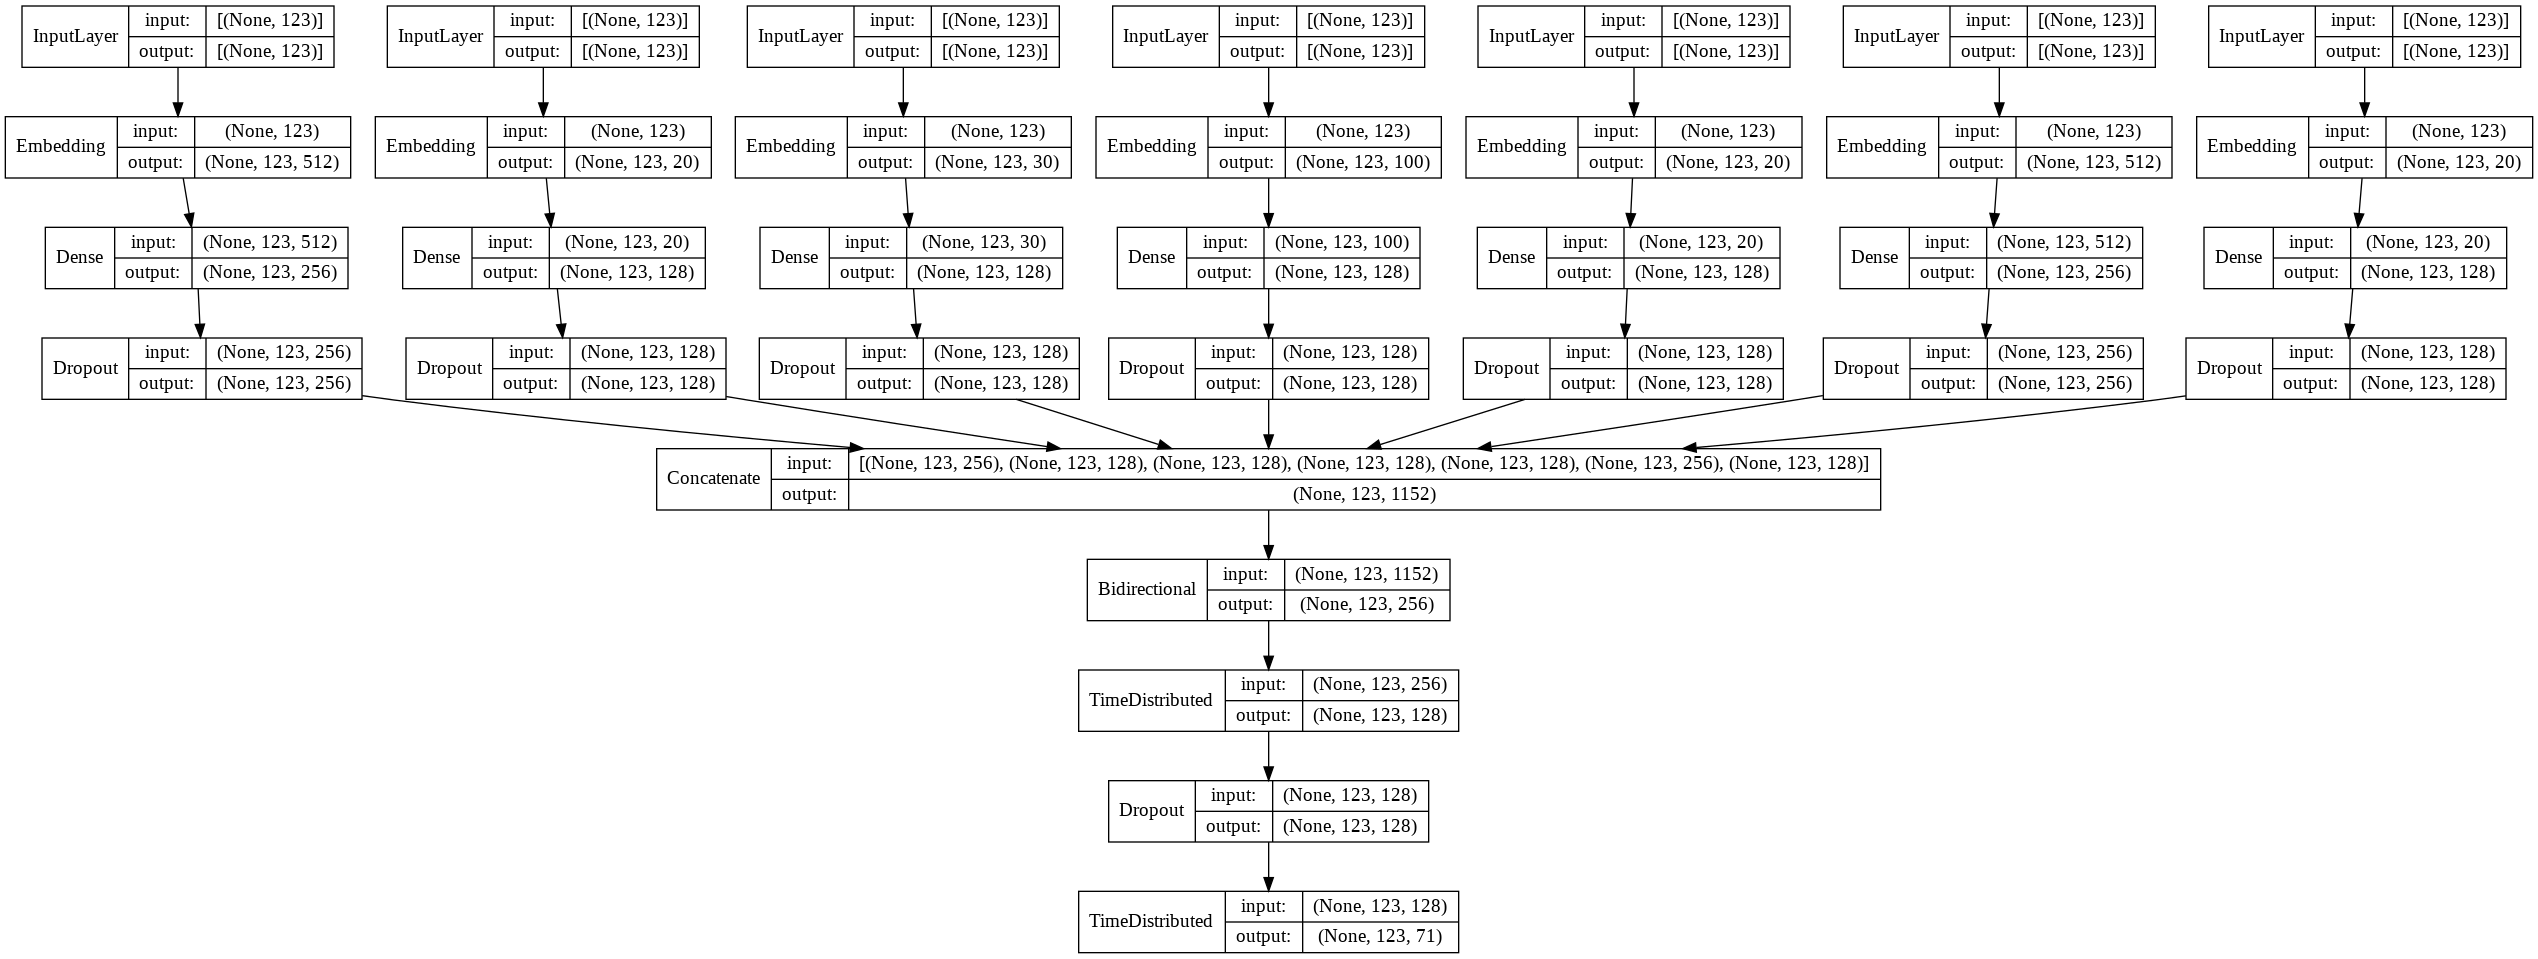

In [168]:
from keras.utils.vis_utils import plot_model
plot_model(model_4_3, show_shapes=True, show_layer_names=False)

In [169]:
model_4_3.fit([X_train_sent, X_train_pos, X_train_rank, X_train_morph, X_train_rel, X_train_head, X_train_headpos], y_train,
          validation_data=([X_val_sent, X_val_pos, X_val_rank, X_val_morph, X_val_rel, X_val_head, X_val_headpos], y_val),
          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
38/38 [==============================] - 297s 5s/step - loss: 0.2626 - acc: 0.8675 - precision_7: 0.8965 - recall_7: 0.7201 - ignore_accuracy: 0.0100 - val_loss: 0.1340 - val_acc: 0.8984 - val_precision_7: 0.8984 - val_recall_7: 0.8984 - val_ignore_accuracy: 0.0000e+00
Epoch 2/15
38/38 [==============================] - 191s 5s/step - loss: 0.1307 - acc: 0.8981 - precision_7: 0.9012 - recall_7: 0.8835 - ignore_accuracy: 0.0416 - val_loss: 0.1090 - val_acc: 0.8984 - val_precision_7: 0.8987 - val_recall_7: 0.8976 - val_ignore_accuracy: 0.0000e+00
Epoch 3/15
38/38 [==============================] - 192s 5s/step - loss: 0.1098 - acc: 0.8959 - precision_7: 0.9064 - recall_7: 0.8719 - ignore_accuracy: 0.3602 - val_loss: 0.0969 - val_acc: 0.8984 - val_precision_7: 0.9001 - val_recall_7: 0.8971 - val_ignore_accuracy: 0.1588
Epoch 4/15
38/38 [==============================] - 192s 5s/step - loss: 0.1021 - acc: 0.8959 - precision_7: 0.9056 - recall_7: 0.8778 - ignore_accuracy: 0.4062 

In [177]:
model_4_3.save('my_model_4_3')

INFO:tensorflow:Assets written to: my_model_4_3/assets


INFO:tensorflow:Assets written to: my_model_4_3/assets


In [170]:
eval_results_4_3 = model_4_3.evaluate(x=[X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos],
                                y=y_test)

50/50 [==============================] - 22s 446ms/step - loss: 0.0773 - acc: 0.9078 - precision_7: 0.9300 - recall_7: 0.8933 - ignore_accuracy: 0.6772


In [171]:
metrics_df.loc[len(metrics_df)] = ['7 Input, Dense, biLSTM, 2 Dense [3]', eval_results_4_3[0], eval_results_4_3[1], eval_results_4_3[2], eval_results_4_3[3], eval_results_4_3[4]]

In [172]:
metrics_df

,Model type,Loss,Accuracy,Precision,Recall,Custom accuracy
0,"4 Input, biLSTM, Dense",0.079551,0.905396,0.912322,0.899707,0.693643
1,"7 Input, biLSTM, Dense",0.069799,0.908815,0.925157,0.894731,0.599692
2,"7 Input, Dense, biLSTM, Dense",0.066909,0.917183,0.939530,0.899043,0.658773
3,"7 Input, Dense, biLSTM, 2 Dense",0.071474,0.915576,0.940868,0.900804,0.681202
4,"7 Input, Dense, biLSTM, 2 Dense [2]",0.070835,0.917260,0.948581,0.895701,0.617768
5,"7 Input, Dense, biLSTM, 2 Dense [3]",0.077325,0.907820,0.929960,0.893303,0.677185


In [173]:
preds_4_3 = model_4_3.predict([X_test_sent, X_test_pos, X_test_rank, X_test_morph, X_test_rel, X_test_head, X_test_headpos])

In [174]:
pred_pr_4_3 = predicate_precision(y_test, preds_4_3).numpy()
pred_re_4_3 = predicate_recall(y_test, preds_4_3).numpy()
agent_pr_4_3 = agent_precision(y_test, preds_4_3).numpy()
agent_re_4_3 = agent_recall(y_test, preds_4_3).numpy()
patient_pr_4_3 = patient_precision(y_test, preds_4_3).numpy()
patient_re_4_3 = patient_recall(y_test, preds_4_3).numpy()

In [191]:
role_metrics_df.loc[len(role_metrics_df)] = ['7 Input, Dense, biLSTM, 2 Dense [3]', pred_pr_4_3, pred_re_4_3, agent_pr_4_3, agent_re_4_3, patient_pr_4_3, patient_re_4_3]

In [192]:
role_metrics_df

,Model type,Predicate Precision,Predicate Recall,Agent Precision,Agent Recall,Patient Precision,Patient Recall
0,"4 Input, biLSTM, Dense",0.706337,0.322058,0.250000,0.003497,0.000000,0.000
1,"7 Input, biLSTM, Dense",0.635135,0.496829,0.488372,0.073427,0.483871,0.060
2,"7 Input, Dense, biLSTM, Dense",0.726502,0.664553,0.451613,0.195804,0.413333,0.124
3,"7 Input, Dense, biLSTM, 2 Dense",0.751177,0.674419,0.352941,0.083916,0.247525,0.100
4,"7 Input, Dense, biLSTM, 2 Dense [2]",0.697285,0.850599,0.330986,0.164336,0.277512,0.232
5,"7 Input, Dense, biLSTM, 2 Dense [3]",0.679764,0.487667,0.375000,0.010490,0.000000,0.000


# Предсказание

In [ ]:
data_file = open("ru_syntagrus-ud-test.conllu", "r", encoding="utf-8")
rows = data_file.read().strip().split('#')[1:]

In [ ]:
syntagrus = pd.DataFrame()
for i in tqdm(range(len(rows))):
    if i % 2 == 0:
        id = rows[i].split('=')[1].strip()
    else:
        new_sent = []
        words = rows[i].split('\n')[1:-2]
        for word in words:
            info = word.split('\t') + [id]
            new_sent.append(info)
        syntagrus = syntagrus.append(pd.DataFrame(new_sent), ignore_index=True)

100%|██████████| 12982/12982 [01:43<00:00, 125.86it/s]


In [ ]:
syntagrus.columns = ['index', 'wordform', 'lemma', 'POS', 'Xpos', 'features', 'parent', 'link_name', 'relation', 'space', 'FullIndex']

In [ ]:
syntagrus.head()

,index,wordform,lemma,POS,Xpos,features,parent,link_name,relation,space,FullIndex
0,1,В,в,ADP,_,_,3,case,3:case,_,2003Armeniya.xml_1
1,2,советский,советский,ADJ,_,Animacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|N...,3,amod,3:amod,_,2003Armeniya.xml_1
2,3,период,период,NOUN,_,Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing,11,obl,11:obl,_,2003Armeniya.xml_1
3,4,времени,время,NOUN,_,Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing,3,nmod,3:nmod,_,2003Armeniya.xml_1
4,5,число,число,NOUN,_,Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing,11,obj,11:obj,_,2003Armeniya.xml_1


In [ ]:
len(syntagrus)

117521

In [ ]:
for index, row in tqdm(syntagrus.iterrows()):
    parent = row.parent
    fullindex = row.FullIndex
    if parent != '0':
        value = syntagrus.loc[(syntagrus['FullIndex'] == fullindex) & (syntagrus['index'] == parent)]
        syntagrus.loc[index, 'lemma_parent'] = value['lemma'].values[0]
        syntagrus.loc[index, 'pos_parent'] = value['POS'].values[0]
    else:
        syntagrus.loc[index, 'lemma_parent'] = '_'
        syntagrus.loc[index, 'pos_parent'] = '_'

In [ ]:
syntagrus.to_csv('syntagrus_modified.xlsx', sep='\t')

In [112]:
syntagrus = pd.read_csv('syntagrus_modified.xlsx', sep='\t', index_col=0)

In [113]:
syntagrus.drop(syntagrus[syntagrus.parent == '_'].index, inplace=True)

In [114]:
def create_parent_index(self_index, parent_index):
    if int(parent_index) != 0:
        return int(parent_index) - int(self_index)
    else:
        return 0

In [115]:
syntagrus['rel'] = syntagrus[['index', 'parent']].progress_apply(lambda x: create_parent_index(*x), axis=1)

100%|██████████| 117327/117327 [00:01<00:00, 96214.21it/s] 


In [116]:
sent_groups = syntagrus.groupby('FullIndex').indices
sent_indices = sent_groups.keys()

In [117]:
sent_max_len = syntagrus['FullIndex'].value_counts().max()

In [118]:
def data2ints(column, smth2id):
    int_data = []
    for full_index in sent_indices:
        start = sent_groups[full_index][0]
        end = sent_groups[full_index][-1]
        seq = column[start:end+1]
        int_seq = []
        for i in seq:
            int_seq.append(smth2id.get(i, 1))
        int_data.append(int_seq)
    return int_data

In [119]:
X_synt_sent_ids = data2ints(syntagrus.lemma, word2id)
X_synt_pos_ids = data2ints(syntagrus.POS, pos2id)
X_synt_rank_ids = data2ints(syntagrus.link_name, rank2id)
X_synt_morph_ids = data2ints(syntagrus.features, morph2id)
X_synt_rel_ids = data2ints(syntagrus.rel, rel2id)
X_synt_head_ids = data2ints(syntagrus.lemma_parent, word2id)
X_synt_headpos_ids = data2ints(syntagrus.pos_parent, pos2id)

In [120]:
X_synt_sent = pad_sequences(X_synt_sent_ids, maxlen=sent_max_len, padding='post')
X_synt_pos = pad_sequences(X_synt_pos_ids, maxlen=sent_max_len, padding='post')
X_synt_rank = pad_sequences(X_synt_rank_ids, maxlen=sent_max_len, padding='post')
X_synt_morph = pad_sequences(X_synt_morph_ids, maxlen=sent_max_len, padding='post')
X_synt_rel = pad_sequences(X_synt_rel_ids, maxlen=sent_max_len, padding='post')
X_synt_head = pad_sequences(X_synt_head_ids, maxlen=sent_max_len, padding='post')
X_synt_headpos = pad_sequences(X_synt_headpos_ids, maxlen=sent_max_len, padding='post')

## Предсказание модели 4

In [121]:
y_pred = model_4.predict([X_synt_sent, X_synt_pos, X_synt_rank, X_synt_morph, X_synt_rel, X_synt_head, X_synt_headpos])

In [122]:
all_roles = []
for y in tqdm(y_pred):
    for pred in y:
        try:
            all_roles.append(id2role[np.argmax(pred)])
        except:
            pass

100%|██████████| 6491/6491 [00:02<00:00, 3129.28it/s]


In [123]:
Counter(all_roles)

Counter({'_': 797107,
         'агенс': 39,
         'говорящий': 1,
         'пациенс': 33,
         'предикат': 1158,
         'причина': 25,
         'субъект перемещения': 2,
         'субъект психологического состояния': 23,
         'тема': 5})

In [124]:
final_df = pd.DataFrame()

for key, roles in tqdm(list(zip(sent_indices, y_pred))):
    max_len = len(sent_groups[key])
    list_of_roles = []
    for pred in roles[:max_len]:
        list_of_roles.append(id2role[np.argmax(pred)])
    new_df = syntagrus[syntagrus['FullIndex'] == key]
    new_df['role'] = list_of_roles
    final_df = final_df.append(new_df, ignore_index=True)

100%|██████████| 6491/6491 [04:04<00:00, 26.55it/s]


In [126]:
final_df.drop(['lemma_parent', 'pos_parent', 'rel'], axis=1).to_csv('final_df_model_4.xlsx', sep='\t')

## Предсказание модели 3

In [127]:
y_pred = model_3.predict([X_synt_sent, X_synt_pos, X_synt_rank, X_synt_morph, X_synt_rel, X_synt_head, X_synt_headpos])

In [128]:
all_roles = []
for y in tqdm(y_pred):
    for pred in y:
        try:
            all_roles.append(id2role[np.argmax(pred)])
        except:
            pass

100%|██████████| 6491/6491 [00:02<00:00, 3132.32it/s]


In [129]:
Counter(all_roles)

Counter({'_': 796514,
         'агенс': 162,
         'адресат': 6,
         'говорящий': 77,
         'конечная точка': 9,
         'место': 6,
         'пациенс': 46,
         'пациенс перемещения': 2,
         'предикат': 1351,
         'причина': 20,
         'результат': 9,
         'содержание высказывания': 6,
         'содержание мысли': 1,
         'субъект перемещения': 78,
         'субъект психологического состояния': 36,
         'тема': 70})

In [178]:
final_df_3 = pd.DataFrame()

for key, roles in tqdm(list(zip(sent_indices, y_pred))):
    max_len = len(sent_groups[key])
    list_of_roles = []
    for pred in roles[:max_len]:
        list_of_roles.append(id2role[np.argmax(pred)])
    new_df = syntagrus[syntagrus['FullIndex'] == key]
    new_df['role'] = list_of_roles
    final_df_3 = final_df_3.append(new_df, ignore_index=True)

100%|██████████| 6491/6491 [04:04<00:00, 26.52it/s]


In [179]:
final_df_3.head()

,index,wordform,lemma,POS,Xpos,features,parent,link_name,relation,space,FullIndex,lemma_parent,pos_parent,rel,role
0,1,В,в,ADP,_,_,3,case,3:case,_,2003Armeniya.xml_1,период,NOUN,2,_
1,2,советский,советский,ADJ,_,Animacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|N...,3,amod,3:amod,_,2003Armeniya.xml_1,период,NOUN,1,_
2,3,период,период,NOUN,_,Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing,11,obl,11:obl,_,2003Armeniya.xml_1,составлять,VERB,8,_
3,4,времени,время,NOUN,_,Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing,3,nmod,3:nmod,_,2003Armeniya.xml_1,период,NOUN,-1,_
4,5,число,число,NOUN,_,Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing,11,obj,11:obj,_,2003Armeniya.xml_1,составлять,VERB,6,_


In [188]:
Counter(final_df_3[final_df_3.role == 'субъект психологического состояния']['lemma_parent'])

Counter({'беспокоиться': 1,
         'бояться': 4,
         'волновать': 5,
         'волноваться': 1,
         'жаждать': 1,
         'любить': 6,
         'любоваться': 1,
         'мечтать': 4,
         'надоесть': 1,
         'опасаться': 1,
         'предпочитать': 1,
         'привыкнуть': 3,
         'радовать': 1,
         'смущать': 1,
         'стремиться': 1,
         'уставать': 1,
         'устать': 3})

In [180]:
final_df_3.drop(['lemma_parent', 'pos_parent', 'rel'], axis=1).to_csv('final_df_model_3.xlsx', sep='\t')

In [189]:
final_df_3.to_csv('df_3_with_head.xlsx', sep='\t')